##  EXPERIMENT USING STARS, EXOPLANETS AND QUASARS


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


## checking for missing/null values (extra caution before starting the new experiment)

In [5]:
# dealing with any missing/null values for stars, exopalnets and quasars datasets 
stars_df = pd.read_csv("../../data/full/stars_gaia_clean.csv")
print(stars_df.isnull().sum())
print(stars_df.info())

exo_df = pd.read_csv("../../data/full/exoplanets_clean.csv")
print(exo_df.isnull().sum())
print(exo_df.info())

quasars_df = pd.read_csv("../../data/full/quasars_gaia_clean.csv")
print(quasars_df.isnull().sum())
print(quasars_df.info())

source_id          0
ra                 0
dec                0
parallax           0
pmra               0
pmdec              0
phot_g_mean_mag    0
bp_rp              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   source_id        50000 non-null  int64  
 1   ra               50000 non-null  float64
 2   dec              50000 non-null  float64
 3   parallax         50000 non-null  float64
 4   pmra             50000 non-null  float64
 5   pmdec            50000 non-null  float64
 6   phot_g_mean_mag  50000 non-null  float64
 7   bp_rp            50000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB
None
rowid              0
pl_name            0
hostname           0
pl_letter          0
gaia_id            0
discoverymethod    0
disc_year          0
pl_orbper          0
pl_orbsmax         0
st_teff

## Loading Data 


In [6]:
# Laad datasets
stars_df = pd.read_csv("../../data/full/stars_gaia_clean.csv").assign(label="star")
exo_df = pd.read_csv("../../data/full/exoplanets_clean.csv").assign(label="exo_host")
quasars_df = pd.read_csv("../../data/full/quasars_gaia_clean.csv").assign(label="quasar")


#align column: exo use sy_plx while stars and qiuasars use parallax
exo_df = exo_df.rename(columns={"sy_plx":"parallax", "sy_pmra":"pmra", "sy_pmdec":"pmdec", "sy_gaiamag":"phot_g_mean_mag"})


# select shared features
features = ["ra", "dec", "parallax", "pmdec", "pmra", "phot_g_mean_mag"]

# Define dataset size for each datasets 
sizes = [10000, 20000, 37800]







In [8]:
exo_df = exo_df.dropna(subset=features)


In [10]:
from sklearn.model_selection import train_test_split

# Trim datasets to only have selected features and drop rows with missing values
stars_df = stars_df[features + ["label"]].dropna()
exo_df = exo_df[features +["label"]].dropna()
quasars_df = quasars_df[features + ["label"]].dropna()



# This satcks the three datasets toghether, so i can threat them as a single multiclass dataset
df = pd.concat([stars_df, exo_df, quasars_df])

# Split in X (Numeric Feature only) and y (Call labels (Star, Exoplanet, Quasar)

X = df[features]
y = df["label"]


# labeled-feature datasets only 
subsets = {}

## Creates a balanced subsets for each dataset size
for n_total in sizes:
    n_per = min(n_total // 3, len(stars_df), len(exo_df), len(quasars_df))

    
    stars_sub = stars_df.sample(n=n_per, random_state=42)
    exo_sub = exo_df.sample(n=n_per, random_state=42)
    quasars_sub = quasars_df.sample(n=n_per, random_state=42)

    df_sub = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    X_n = df_sub[features]
    y_n = df_sub["label"]
    subsets[n_total] = (X_n, y_n)



## Baselien sanity (DummyClassifier)
### I have 3 kinds of objects: Stars, Exoplanets, Quasars. 
### See if the model does better than random guessing, so i make a "dummy" model that just guesses in a simple way, and check how bad it is.
### If tha main model beats this dummy, i know im doing real learning.

In [12]:
print(exo_df.columns)
print(exo_df[features].isna().mean().sort_values(ascending=False))
print("exo rows before dropna:", len(exo_df))



Index(['ra', 'dec', 'parallax', 'pmdec', 'pmra', 'phot_g_mean_mag', 'label'], dtype='object')
ra                 0.0
dec                0.0
parallax           0.0
pmdec              0.0
pmra               0.0
phot_g_mean_mag    0.0
dtype: float64
exo rows before dropna: 37871


In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

X_n, y_n = subsets[10000]

for n in sizes:
    X_n, y_n = subsets[n]

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

accs, f1s = [], []
for train_idx, test_idx in splitter.split(X_n, y_n):
    clf = DummyClassifier(strategy="most_frequent", random_state=42)
    clf.fit(X_n.iloc[train_idx], y_n.iloc[train_idx])
    pred = clf.predict(X_n.iloc[test_idx])
    accs.append(accuracy_score(y_n.iloc[test_idx], pred))
    f1s.append(f1_score(y_n.iloc[test_idx], pred, average="macro"))



print("Dummy most_frequent:", np.mean(accs), np.mean(f1s))



Dummy most_frequent: 0.33333333333333337 0.16666666666666669


## Logistic regression, Random Forest and Multi-layer perception (Main supervised models)

In [14]:
from sklearn.model_selection import StratifiedKFold

## Main supervised models (LogReg, RF, MPL)


#align column: exo use sy_plx while stars and qiuasars use parallax
exo_df = exo_df.rename(columns={"sy_plx":"parallax", "sy_pmra":"pmra", "sy_pmdec":"pmdec", "sy_gaiamag":"phot_g_mean_mag"})


# select shared features
features = ["ra", "dec", "parallax", "pmdec", "pmra", "phot_g_mean_mag"]

# Define dataset size for each datasets 
sizes = [10000, 20000, 37800]

# Trim datasets to only have selected features and drop rows with missing values
stars = stars_df[features + ["label"]].dropna()
exo = exo_df[features +["label"]].dropna()
quasars = quasars_df[features + ["label"]].dropna()

def eval_size_logreg(n_total, k=5):
    n_per = min(n_total // 3, len(exo), len(stars), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub, quasars_sub], ignore_index=True)
    X = df[features].values
    y = df["label"].values

    # 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # K-fold on train+val
    skf= StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s, precs, recs = [], [], [], []
    

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
       
        )
        accs.append(accuracy_score(y_trainval[val_idx], pred))
        precs.append(p); recs.append(r); f1s.append(f1)

    #Final test evaluation
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0

    )
       
        
    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_f1_mean": np.mean(f1s),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1,
    }
  
for size in sizes:
    print(eval_size_logreg(size))

{'size': 9999, 'cv_acc_mean': np.float64(0.9768718730456534), 'cv_f1_mean': np.float64(0.976862731897362), 'cv_prec_mean': np.float64(0.9769323448957297), 'cv_rec_mean': np.float64(0.9768741231059674), 'test_acc': 0.98, 'test_prec': 0.9800338185206606, 'test_rec': 0.9799987393690542, 'test_f1': 0.9800060791092182}
{'size': 19998, 'cv_acc_mean': np.float64(0.9789972452328852), 'cv_f1_mean': np.float64(0.9789909565328407), 'cv_prec_mean': np.float64(0.9790669697874088), 'cv_rec_mean': np.float64(0.9789967722328798), 'test_acc': 0.9775, 'test_prec': 0.9776728574901502, 'test_rec': 0.9775052458766865, 'test_f1': 0.9774955659425189}
{'size': 37800, 'cv_acc_mean': np.float64(0.9793650793650794), 'cv_f1_mean': np.float64(0.979360188244702), 'cv_prec_mean': np.float64(0.9793968224565626), 'cv_rec_mean': np.float64(0.9793650793650794), 'test_acc': 0.9801587301587301, 'test_prec': 0.9802128446281461, 'test_rec': 0.9801587301587302, 'test_f1': 0.9801504564175861}


## Rendom Forest


In [15]:

from sklearn.model_selection import StratifiedKFold

##random forest model 
def eval_size_rf(total, k=5):
    n_per = min(total // 3, len(exo), len(stars), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub, quasars_sub], ignore_index= True)
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=features)

    X = df[features].values
    y = df["label"].values

    #80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )


    #k-fold on train+val
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s, precs, recs = [], [], [], []
    

    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        y_pred = clf.predict(X_trainval[val_idx])
        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], y_pred, average="macro", zero_division=0
            
        ) 
        accs.append(accuracy_score(y_trainval[val_idx], y_pred))
        precs.append(p); recs.append(r); f1s.append(f1)

    #FInal test evaluation (after CV)
    clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )
        
     

        

    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1,


    }
        
for size in sizes:
    print(eval_size_rf(size))

{'size': 9999, 'cv_acc_mean': np.float64(0.9977496873045654), 'cv_prec_mean': np.float64(0.9977581499059973), 'cv_rec_mean': np.float64(0.997749998243284), 'cv_f1_mean': np.float64(0.9977496329251382), 'test_acc': 0.997, 'test_prec': 0.9970238095238096, 'test_rec': 0.9970014992503748, 'test_f1': 0.9969992075927027}
{'size': 19998, 'cv_acc_mean': np.float64(0.9989998827758674), 'cv_prec_mean': np.float64(0.999003579791891), 'cv_rec_mean': np.float64(0.9989998435057524), 'cv_f1_mean': np.float64(0.9989998984082238), 'test_acc': 0.999, 'test_prec': 0.9990027424582398, 'test_rec': 0.999000499750125, 'test_f1': 0.9990001237192249}
{'size': 37800, 'cv_acc_mean': np.float64(0.9993055555555556), 'cv_prec_mean': np.float64(0.9993066513916095), 'cv_rec_mean': np.float64(0.9993055555555556), 'cv_f1_mean': np.float64(0.9993055463507234), 'test_acc': 0.9996031746031746, 'test_prec': 0.9996032270308265, 'test_rec': 0.9996031746031746, 'test_f1': 0.9996031745875525}


## Multi-Layer Preceptron (MLP)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedKFold

def eval_size_mlp(n_total, k=5):
    n_per = min(n_total // 3, len(stars), len(exo), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    # Encode labels to integers for MLP
    le = LabelEncoder()
    X = df[features].values
    y = le.fit_transform(df["label"].values)
    
    # 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test, = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    # K-fold on train+val
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []
    

    clf = make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000,
                      early_stopping=True, random_state=42)
    )

    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)
        accs.append(accuracy_score(y_trainval[val_idx], pred))

    #Final test evaluation
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )

    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1
    }

for size in sizes:
    print(eval_size_mlp(size))


{'size': 9999, 'cv_acc_mean': np.float64(0.98987382739212), 'cv_prec_mean': np.float64(0.9899124649211505), 'cv_rec_mean': np.float64(0.9898759290099383), 'cv_f1_mean': np.float64(0.9898745011353303), 'test_acc': 0.9845, 'test_prec': 0.9845158906663402, 'test_rec': 0.98449348899124, 'test_f1': 0.9844888834043338}
{'size': 19998, 'cv_acc_mean': np.float64(0.9949368161925601), 'cv_prec_mean': np.float64(0.9949640561110087), 'cv_rec_mean': np.float64(0.994935857872745), 'cv_f1_mean': np.float64(0.9949372078571692), 'test_acc': 0.9965, 'test_prec': 0.9965065639705948, 'test_rec': 0.9965009993127967, 'test_f1': 0.9965004251452018}
{'size': 37800, 'cv_acc_mean': np.float64(0.9962632275132275), 'cv_prec_mean': np.float64(0.9962787451471554), 'cv_rec_mean': np.float64(0.9962632275132275), 'cv_f1_mean': np.float64(0.9962632197516683), 'test_acc': 0.9977513227513227, 'test_prec': 0.9977529422258602, 'test_rec': 0.9977513227513227, 'test_f1': 0.997751583426841}


## MLP MInMaxScaler experiment


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd

def eval_size_mlp_scaled(n_total, scaler_type="standard", k=5):
    n_per = min(n_total // 3, len(stars), len(exo), len(quasars))

    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=features)

    X = df[features].values
    y_text = df["label"].values

    #encode labels to integers for MLP 
    le = LabelEncoder()
    y = le.fit_transform(y_text)

    #80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []

    scaler = StandardScaler() if scaler_type == "standard" else MinMaxScaler()

    clf = make_pipeline(
        scaler,
        MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000,
                      early_stopping=True, random_state=42)
    )

    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
        )
        accs.append(accuracy_score(y_trainval[val_idx], pred))
        precs.append(p); recs.append(r); f1s.append(f1)

    #Final test evaluation
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )

    return {
        "size": 3 * n_per,
        "scaler": scaler_type,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1
    }

# Run comparision of standard vs min-max scaling for MLP
mlp_scaler_results = []
for n in sizes:
    mlp_scaler_results.append(eval_size_mlp_scaled(n, scaler_type="standard", k=5))
    mlp_scaler_results.append(eval_size_mlp_scaled(n, scaler_type="minmax", k=5))

mlp_scaler_df = pd.DataFrame(mlp_scaler_results)
mlp_scaler_df

,size,cv_acc_mean,cv_prec_mean,cv_rec_mean,cv_f1_mean,test_acc,test_prec,test_rec,test_f1
0,9999,0.989874,0.989912,0.989876,0.989875,0.984500,0.984516,0.984493,0.984489
1,9999,0.988749,0.988833,0.988754,0.988748,0.983000,0.982989,0.982996,0.982990
2,19998,0.994937,0.994964,0.994936,0.994937,0.996500,0.996507,0.996501,0.996500
3,19998,0.993062,0.993117,0.993062,0.993060,0.993000,0.992998,0.993001,0.992998
4,37800,0.996263,0.996279,0.996263,0.996263,0.997751,0.997753,0.997751,0.997752
5,37800,0.996362,0.996380,0.996362,0.996362,0.998810,0.998810,0.998810,0.998809


## Plot performance comparision (MLP standard vs MLP MinMax Scaler Plot)

In [ ]:
plt.figure(figsize=(7,5))
sns.lineplot(data=mlp_scaler_df, x="size", y="test_f1", hue="scaler", marker="o")
plt.title("MLP Test F1: StandardScaler vs MinMaxScaler")
plt.xlabel("Total samples (balanced)")
plt.ylabel("Test F1 (macro)")
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()


## KNN (MinMaxScaler), Decison Tree and SVM 

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone
import numpy as np
import pandas as pd


def eval_model_multiclass(n_total, model, k=5):
    n_per = min(n_total // 3, len(stars), len(exo), len(quasars))

    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    df[features] = df[features].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=features)

    X = df[features].values
    y = df["label"].values

    # 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # K-fold on train+val
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []

    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf = clone(model)
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
        )
        accs.append(accuracy_score(y_trainval[val_idx], pred))
        precs.append(p)
        recs.append(r)
        f1s.append(f1)

    # Final test evaluation
    clf = clone(model)
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)

    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )

    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1,
    }

models_extra = {
    # kNN use MinMaxScaler 
    "KNN_MinMax": make_pipeline(
        MinMaxScaler(),
        KNeighborsClassifier(n_neighbors=7, weights="distance")
    ),

    # Decision Tree -> no scaling needed
    "DecisionTree": DecisionTreeClassifier(
        max_depth=12,            # regularization (prevents overfitting)
        min_samples_leaf=5,      # regularization
        random_state=42
    ),

    # SVMs use StandardScaler (very important!!!!!!!!!)
    "SVM_Linear": make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", C=1.0)
    ),

    "SVM_RBF": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=1.0, gamma="scale")
    ),

    "SVM_Poly": make_pipeline(
        StandardScaler(),
        SVC(kernel="poly", degree=3, C=1.0, gamma="scale")
    ),
}


extra_results = []

for model_name, model in models_extra.items():
    # SVM poly/rbf can be slow on large size, (need to remember to change the sizes before running the experiments)
    run_sizes = sizes
    if model_name in ["SVM_RBF", "SVM_Poly"]:
        run_sizes = [10000, 20000]   

    for n in run_sizes:
        row = eval_model_multiclass(n, model, k=5)
        row["model"] = model_name
        extra_results.append(row)
        print(model_name, row)

extra_df = pd.DataFrame(extra_results)
extra_df

KNN_MinMax {'size': 9999, 'cv_acc_mean': np.float64(0.9957493746091306), 'cv_prec_mean': np.float64(0.9957780999825253), 'cv_rec_mean': np.float64(0.9957506212918655), 'cv_f1_mean': np.float64(0.9957475709884438), 'test_acc': 0.997, 'test_prec': 0.997001485750304, 'test_rec': 0.9969999984992488, 'test_f1': 0.9969992481236859, 'model': 'KNN_MinMax'}
KNN_MinMax {'size': 19998, 'cv_acc_mean': np.float64(0.9975621678649578), 'cv_prec_mean': np.float64(0.9975683106852049), 'cv_rec_mean': np.float64(0.9975622650754661), 'cv_f1_mean': np.float64(0.997561666640577), 'test_acc': 0.99925, 'test_prec': 0.9992520568436799, 'test_rec': 0.9992498124531132, 'test_f1': 0.9992500920514115, 'model': 'KNN_MinMax'}
KNN_MinMax {'size': 37800, 'cv_acc_mean': np.float64(0.9987103174603174), 'cv_prec_mean': np.float64(0.998711347312194), 'cv_rec_mean': np.float64(0.9987103174603174), 'cv_f1_mean': np.float64(0.9987101605149699), 'test_acc': 0.9997354497354497, 'test_prec': 0.999735659529474, 'test_rec': 0.999

,size,cv_acc_mean,cv_prec_mean,cv_rec_mean,cv_f1_mean,test_acc,test_prec,test_rec,test_f1,model
0,9999,0.995749,0.995778,0.995751,0.995748,0.997000,0.997001,0.997000,0.996999,KNN_MinMax
1,19998,0.997562,0.997568,0.997562,0.997562,0.999250,0.999252,0.999250,0.999250,KNN_MinMax
2,37800,0.998710,0.998711,0.998710,0.998710,0.999735,0.999736,0.999735,0.999735,KNN_MinMax
3,9999,0.992999,0.993014,0.993000,0.993001,0.995000,0.995026,0.995001,0.995003,DecisionTree
4,19998,0.995937,0.995943,0.995937,0.995937,0.996000,0.995999,0.996000,0.996000,DecisionTree
5,37800,0.997884,0.997886,0.997884,0.997884,0.998413,0.998414,0.998413,0.998413,DecisionTree
6,9999,0.982623,0.982671,0.982624,0.982623,0.983500,0.983525,0.983498,0.983491,SVM_Linear
7,19998,0.984498,0.984546,0.984498,0.984496,0.984000,0.984122,0.984004,0.983999,SVM_Linear
8,37800,0.983664,0.983705,0.983664,0.983663,0.984656,0.984701,0.984656,0.984654,SVM_Linear
9,9999,0.989124,0.989126,0.989125,0.989123,0.983500,0.983499,0.983494,0.983489,SVM_RBF


In [19]:
logreg_results = [eval_size_logreg(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]
mlp_results = [eval_size_mlp(n) for n in sizes]


## Main Model comparision plots (LogReg/RF/MLP)

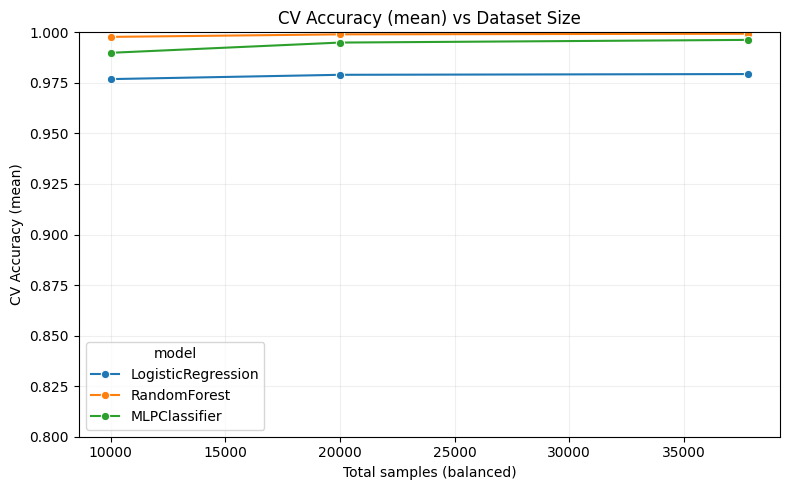

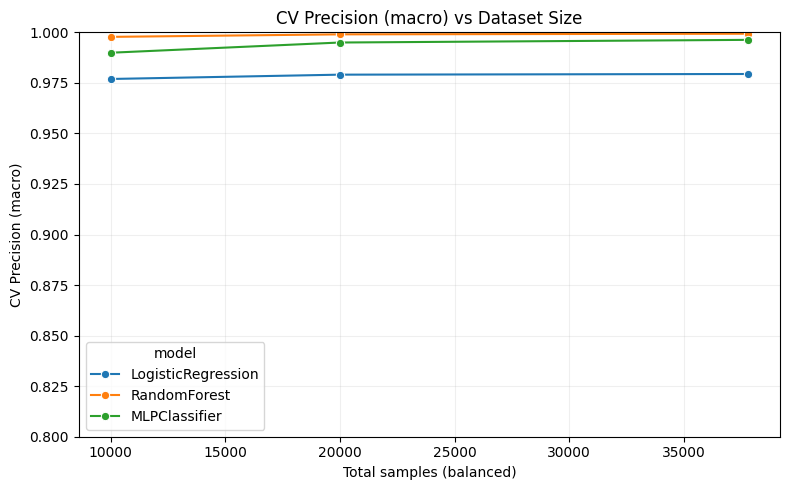

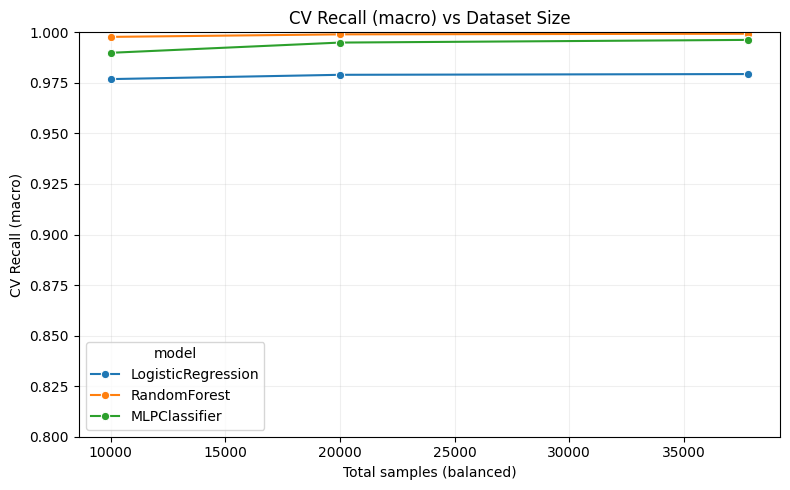

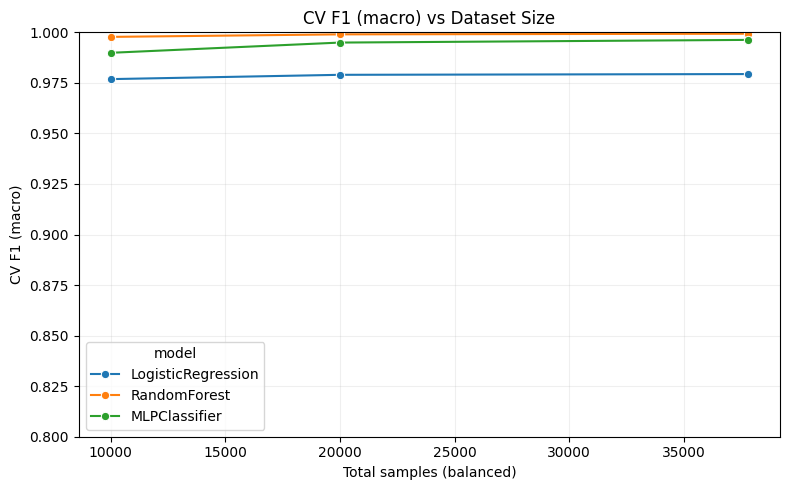

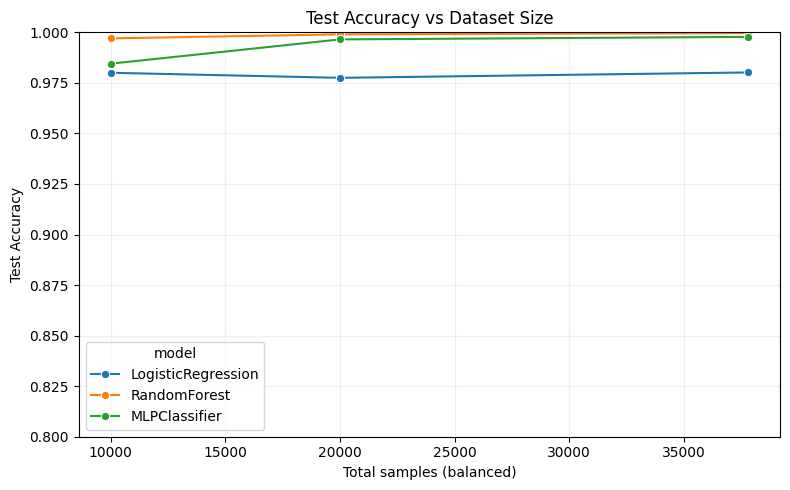

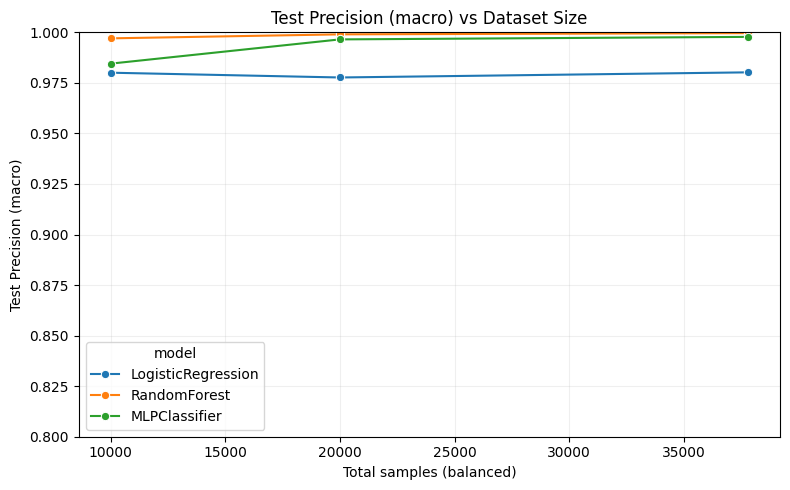

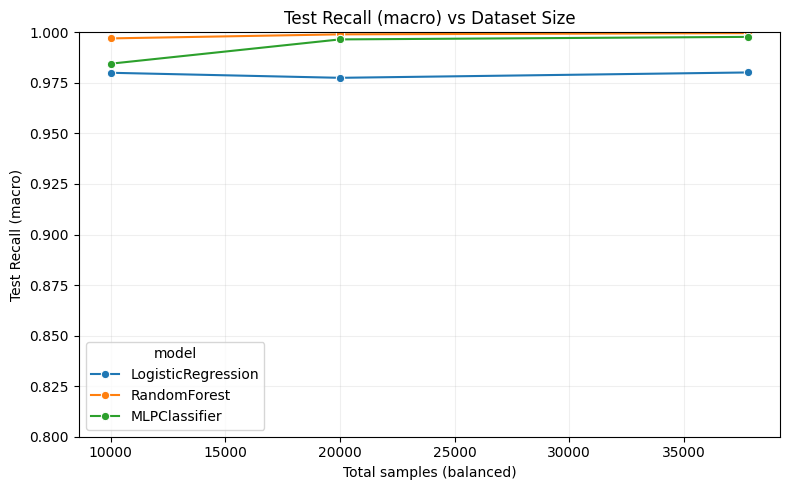

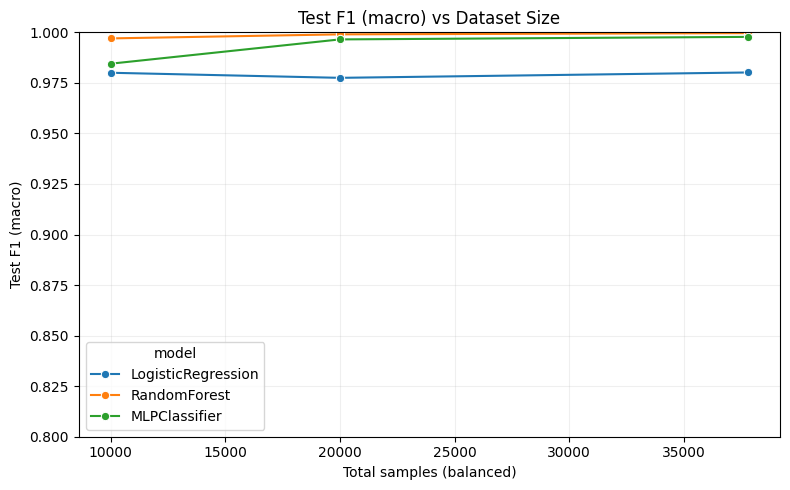

,size,cv_acc_mean,cv_f1_mean,cv_prec_mean,cv_rec_mean,test_acc,test_prec,test_rec,test_f1,model
0,9999,0.976872,0.976863,0.976932,0.976874,0.980000,0.980034,0.979999,0.980006,LogisticRegression
1,19998,0.978997,0.978991,0.979067,0.978997,0.977500,0.977673,0.977505,0.977496,LogisticRegression
2,37800,0.979365,0.979360,0.979397,0.979365,0.980159,0.980213,0.980159,0.980150,LogisticRegression
3,9999,0.997750,0.997750,0.997758,0.997750,0.997000,0.997024,0.997001,0.996999,RandomForest
4,19998,0.999000,0.999000,0.999004,0.999000,0.999000,0.999003,0.999000,0.999000,RandomForest
5,37800,0.999306,0.999306,0.999307,0.999306,0.999603,0.999603,0.999603,0.999603,RandomForest
6,9999,0.989874,0.989875,0.989912,0.989876,0.984500,0.984516,0.984493,0.984489,MLPClassifier
7,19998,0.994937,0.994937,0.994964,0.994936,0.996500,0.996507,0.996501,0.996500,MLPClassifier
8,37800,0.996263,0.996263,0.996279,0.996263,0.997751,0.997753,0.997751,0.997752,MLPClassifier


In [20]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rebuild dataframes from your result lists
def_log = pd.DataFrame(logreg_results)
def_log["model"] = "LogisticRegression"

def_rf = pd.DataFrame(rf_results)
def_rf["model"] = "RandomForest"

def_mlp = pd.DataFrame(mlp_results)
def_mlp["model"] = "MLPClassifier"

df_plot = pd.concat([def_log, def_rf, def_mlp], ignore_index=True)

plot_dir = Path("../../Main_plts/supervised_models")
plot_dir.mkdir(parents=True, exist_ok=True)

# Supports both your old metrics and your newer CV/test metrics
metric_title_map = {
    "acc_mean": "Accuracy",
    "prec_mean": "Precision (macro)",
    "rec_mean": "Recall (macro)",
    "f1_mean": "F1 (macro)",
    "acc_gap": "Train-Test Accuracy Gap",
    "cv_acc_mean": "CV Accuracy (mean)",
    "cv_prec_mean": "CV Precision (macro)",
    "cv_rec_mean": "CV Recall (macro)",
    "cv_f1_mean": "CV F1 (macro)",
    "test_acc": "Test Accuracy",
    "test_prec": "Test Precision (macro)",
    "test_rec": "Test Recall (macro)",
    "test_f1": "Test F1 (macro)",
}

metrics = [m for m in metric_title_map if m in df_plot.columns]

for m in metrics:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{metric_title_map[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(metric_title_map[m])
    if m != "acc_gap":
        plt.ylim(0.8, 1.0)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

df_plot


 ## (KNN / DT / SVM)

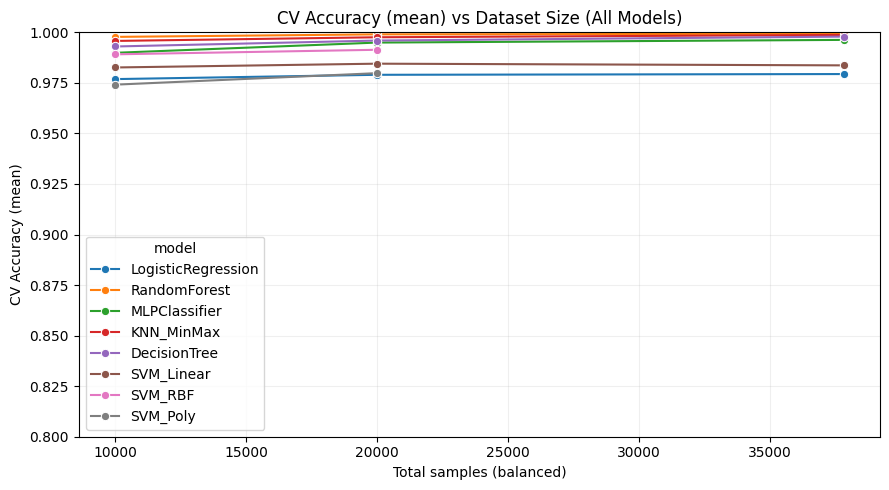

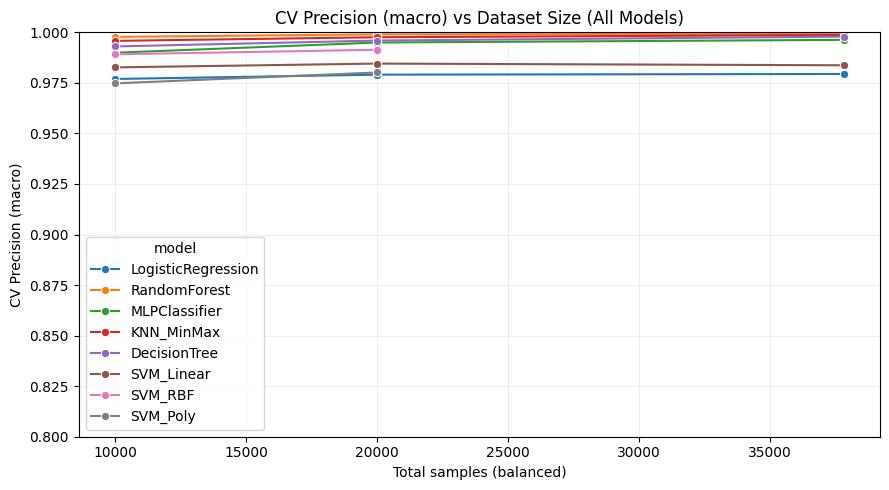

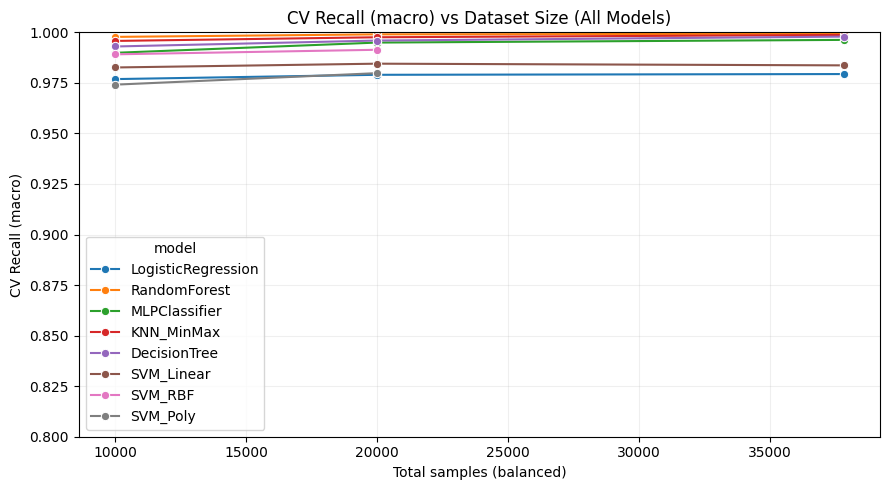

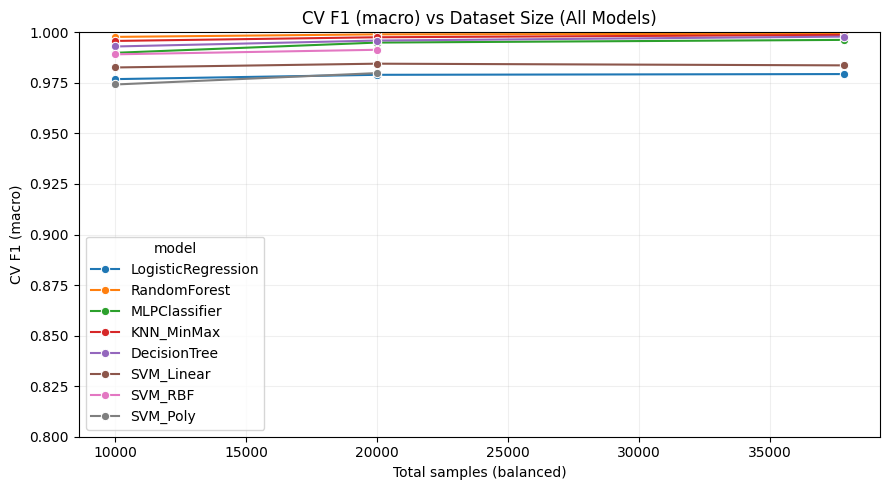

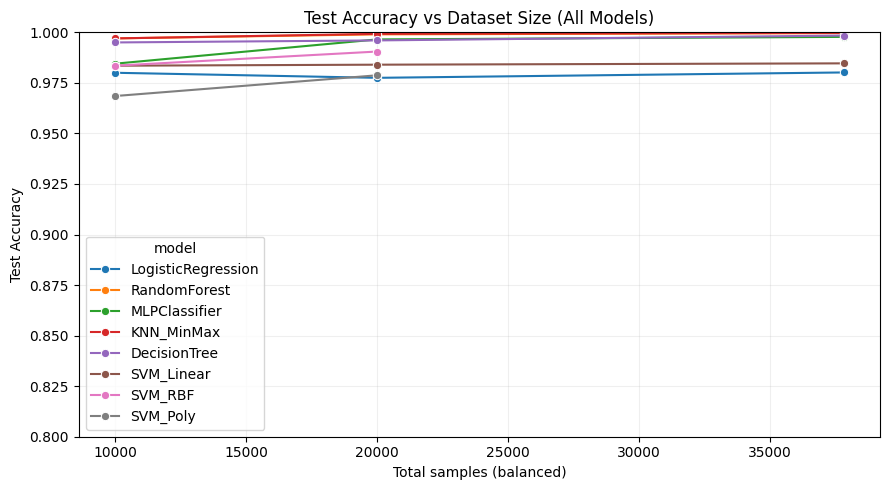

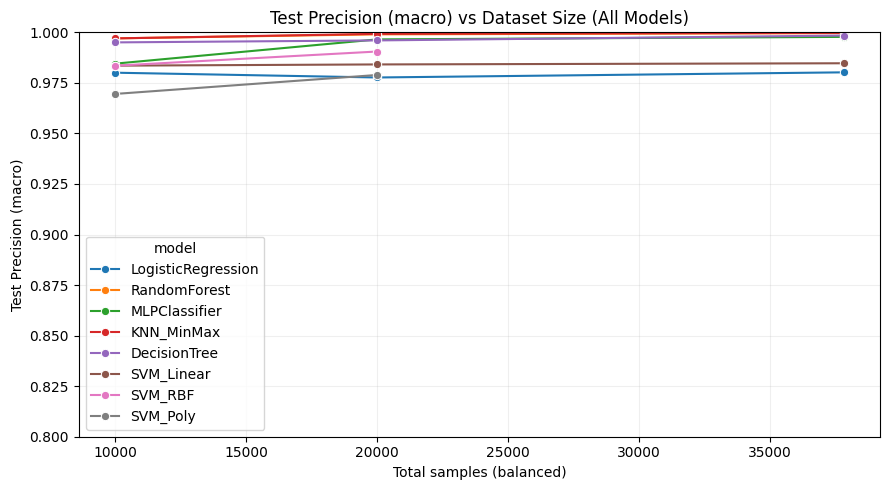

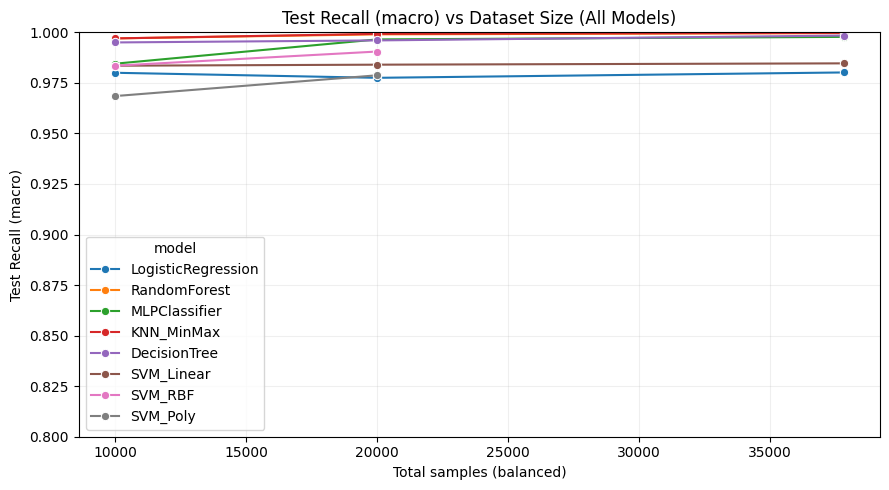

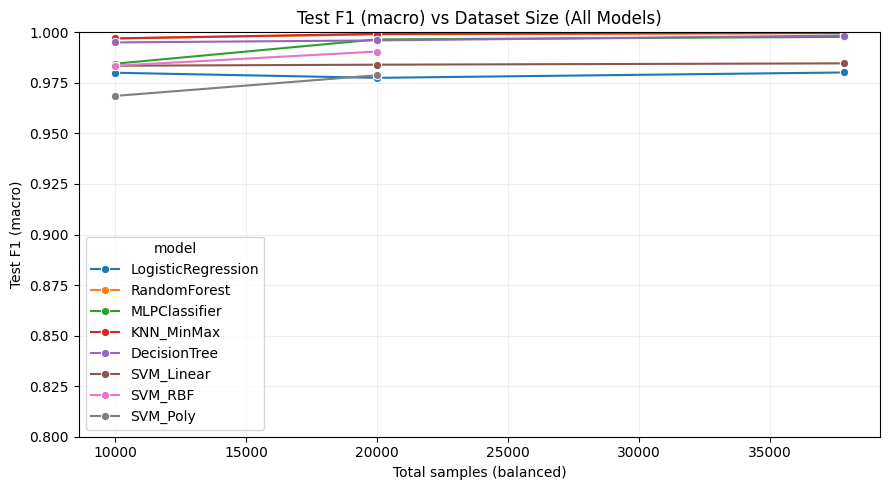

,size,cv_acc_mean,cv_f1_mean,cv_prec_mean,cv_rec_mean,test_acc,test_prec,test_rec,test_f1,model
0,9999,0.976872,0.976863,0.976932,0.976874,0.980000,0.980034,0.979999,0.980006,LogisticRegression
1,19998,0.978997,0.978991,0.979067,0.978997,0.977500,0.977673,0.977505,0.977496,LogisticRegression
2,37800,0.979365,0.979360,0.979397,0.979365,0.980159,0.980213,0.980159,0.980150,LogisticRegression
3,9999,0.997750,0.997750,0.997758,0.997750,0.997000,0.997024,0.997001,0.996999,RandomForest
4,19998,0.999000,0.999000,0.999004,0.999000,0.999000,0.999003,0.999000,0.999000,RandomForest
5,37800,0.999306,0.999306,0.999307,0.999306,0.999603,0.999603,0.999603,0.999603,RandomForest
6,9999,0.989874,0.989875,0.989912,0.989876,0.984500,0.984516,0.984493,0.984489,MLPClassifier
7,19998,0.994937,0.994937,0.994964,0.994936,0.996500,0.996507,0.996501,0.996500,MLPClassifier
8,37800,0.996263,0.996263,0.996279,0.996263,0.997751,0.997753,0.997751,0.997752,MLPClassifier
9,9999,0.995749,0.995748,0.995778,0.995751,0.997000,0.997001,0.997000,0.996999,KNN_MinMax


In [21]:

if "extra_df" in globals() and not extra_df.empty:
    df_plot_all = pd.concat([df_plot, extra_df], ignore_index=True)
else:
    df_plot_all = df_plot.copy()

plot_dir_all = Path("../../Main_plts/supervised_models_all")
plot_dir_all.mkdir(parents=True, exist_ok=True)

metrics_all = [m for m in [
    "cv_acc_mean", "cv_prec_mean", "cv_rec_mean", "cv_f1_mean",
    "test_acc", "test_prec", "test_rec", "test_f1"
] if m in df_plot_all.columns]

titles_all = {
    "cv_acc_mean": "CV Accuracy (mean)",
    "cv_prec_mean": "CV Precision (macro)",
    "cv_rec_mean": "CV Recall (macro)",
    "cv_f1_mean": "CV F1 (macro)",
    "test_acc": "Test Accuracy",
    "test_prec": "Test Precision (macro)",
    "test_rec": "Test Recall (macro)",
    "test_f1": "Test F1 (macro)",
}

for m in metrics_all:
    plt.figure(figsize=(9, 5))
    sns.lineplot(data=df_plot_all, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles_all[m]} vs Dataset Size (All Models)")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles_all[m])
    plt.ylim(0.8, 1.0)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(plot_dir_all / f"{m}_vs_size_all_models.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

df_plot_all


##  MLP StandardScaler vs MinMaxScaler comparison plots

In [23]:
# Only if you created mlp_scaler_df
if "mlp_scaler_df" in globals():
    scaler_plot_dir = Path("../../Main_plts/mlp_scaler_comparison")
    scaler_plot_dir.mkdir(parents=True, exist_ok=True)

    scaler_metrics = [m for m in ["cv_acc_mean", "cv_f1_mean", "test_acc", "test_f1"] if m in mlp_scaler_df.columns]

    for m in scaler_metrics:
        plt.figure(figsize=(7, 5))
        sns.lineplot(data=mlp_scaler_df, x="size", y=m, hue="scaler", marker="o")
        plt.title(f"MLP {m}: StandardScaler vs MinMaxScaler")
        plt.xlabel("Total samples (balanced)")
        plt.ylabel(m)
        plt.ylim(0.8, 1.0)
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.savefig(scaler_plot_dir / f"{m}_mlp_scaler_compare.png", dpi=200, bbox_inches="tight")
        plt.show()
        plt.close()

mlp_scaler_df


ValueError: Could not interpret value `scaler` for `hue`. An entry with this name does not appear in `data`.

<Figure size 700x500 with 0 Axes>

              precision    recall  f1-score   support

    exo_host       1.00      1.00      1.00      2520
      quasar       1.00      1.00      1.00      2520
        star       1.00      1.00      1.00      2520

    accuracy                           1.00      7560
   macro avg       1.00      1.00      1.00      7560
weighted avg       1.00      1.00      1.00      7560



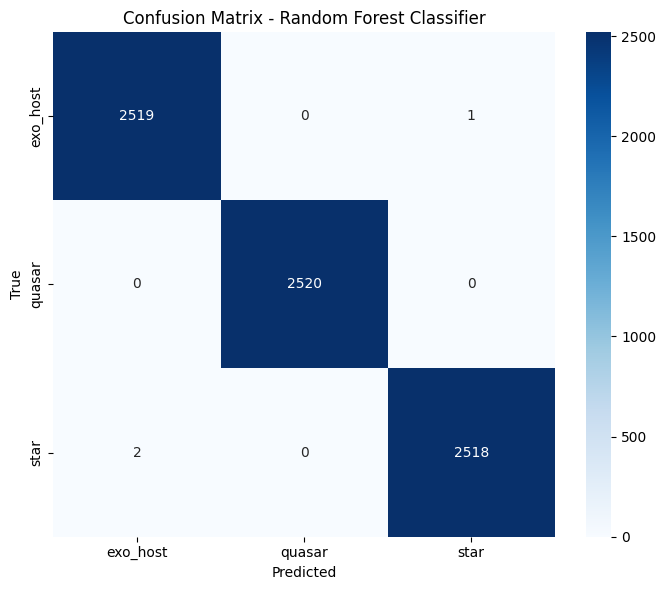

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Using largest dataset size
n_total = 37800
n_per = min(n_total // 3, len(stars), len(exo), len(quasars))

stars_sub = stars.sample(n=n_per, random_state=42)
exo_sub = exo.sample(n=n_per, random_state=42)
quasars_sub = quasars.sample(n=n_per, random_state=42)

df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
X = df[features].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced_subsample"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

plot_dir = Path("../../Main_plots/multiclass_stars_exo_quasars")
plot_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_dir / "confusion_matrix_rf.png", dpi=200, bbox_inches="tight")
plt.show()
